In [2]:
%load_ext autoreload

%autoreload complete

#  Magnus time-evolution for a spin chain

In [3]:
from functools import partial

import cupy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import minimize
from tqdm.auto import tqdm

from qcheff.magnus.system import QuTiPSystem

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["text.usetex"] = False
import numpy as np

from qcheff.magnus.pulses import FourierPulse
from qcheff.spin_chain.utils import embed_operator, setup_magnus_chain_example

In [4]:
chain_size = 3
test_g = 5e-3
test_J = 5e-2
tmax = 25
num_tlist = 1000
num_magnus_intervals = 500
test_tlist = np.linspace(0, tmax, num_tlist)
test_coeffs = [
    0.9025997070283809,
    -0.9999950428875883,
    -0.7361496380026948,
    -0.7132350060400646,
    -0.9143142420450023,
    1.0,
    1.0,
    -1.0,
]


test_system, test_magnus = setup_magnus_chain_example(
    pulse_coeffs=test_coeffs,
    gate_time=tmax,
    chain_size=chain_size,
    num_tlist=num_tlist,
)

TypeError: 'tuple' object is not an iterator

We want to track populations of the $|000...00\rangle$ and $111...11\rangle$ states. So, we will compute expectation values of the corresponding projectors for each of the states obtained from Magnus evolution.

Finally, we can compute the fidelity of our gate using the overlap with the target state.
$$ \mathcal{F} = 1 - |\langle \psi_t|\psi(T)\rangle|^2$$

In [ ]:
test_magnus.dt

np.float64(0.025025025025025027)

Error:  3.14814507795802e-10


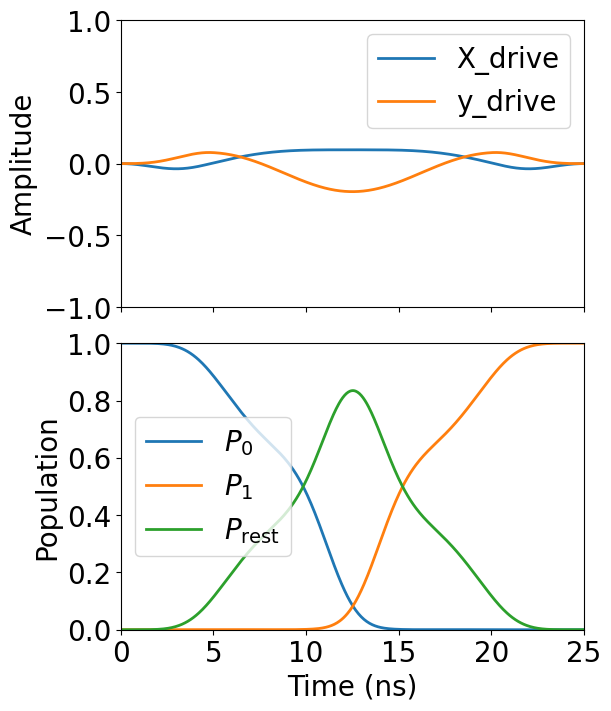

In [ ]:
allzero_state = qt.basis(dimensions=[2] * chain_size, n=[0] * chain_size)
allone_state = qt.basis(dimensions=[2] * chain_size, n=[1] * chain_size)

P0 = allzero_state.proj()
P1 = allone_state.proj()
P_rest = qt.qeye([2] * chain_size) - P0 - P1

test_psi0 = np.asarray((allzero_state).unit()[:])
test_states = [
    qt.Qobj(state, dims=[[2] * chain_size, [1] * chain_size])
    for state in test_magnus.evolve(
        init_state=test_psi0,
        num_intervals=num_magnus_intervals,
        progress_bar=False,
    )
]


eops = [P0, P1, P_rest]
pops = [qt.expect(eop, test_states) for eop in eops]
labels = [r"$P_0$", r"$P_1$", r"$P_{\rm rest}$"]

fig, ax = plt.subplots(2, 1, figsize=(6, 7), layout="constrained", sharex=True)
test_system.plot_control_signals(tlist=test_tlist, axis=ax[0])
mag_tlist = np.linspace(0, tmax, num_magnus_intervals)
for pop, label in zip(pops, labels, strict=False):
    ax[1].plot(mag_tlist, pop, label=label)

ax[1].set(xlim=(0, tmax), xlabel="Time (ns)", ylabel="Population", ylim=(0, 1))
ax[1].legend(loc="best")
infidelity = 1 - qt.expect(P1, test_states[-1])
print("Error: ", infidelity)

Next, given a set of optimal pulse coefficients, we can see how the error of the Magnus expansion changes with the number of Magnus intervals. Note that the total number of points is kept constant, so the number of points per Magnus intervals changes for different number of Magnus intervals. This is done so that the pulse sampling does not need to be changed and we can use the same time list for all these runs.

In [ ]:
import more_itertools

[autoreload of qcheff.spin_chain.utils failed: Traceback (most recent call last):
  File "/home/abhis/miniforge3/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 274, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/home/abhis/miniforge3/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/abhis/miniforge3/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/abhis/miniforge3/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/abhis/miniforge3/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment only supported for mutabl

[Text(0.5, 0, 'Number of Magnus intervals'),
 Text(0, 0.5, 'Infidelity'),
 (1, 1000)]

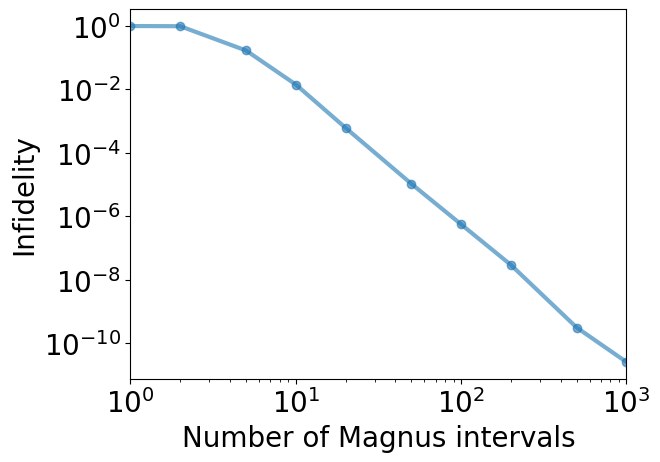

In [ ]:
test_coeffs = [
    0.9025997070283809,
    -0.9999950428875883,
    -0.7361496380026948,
    -0.7132350060400646,
    -0.9143142420450023,
    1.0,
    1.0,
    -1.0,
]
interval_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
err_list = [
    state_transfer_infidelity(
        test_coeffs,
        gate_time=25,
        test_N=3,
        num_tlist=1000,
        num_magnus_intervals=interval,
    )
    for interval in interval_list
]
fig, ax = plt.subplots()
ax.loglog(interval_list, err_list, "o-", alpha=0.6, lw=3)
ax.set(
    xlabel="Number of Magnus intervals",
    ylabel="Infidelity",
    xlim=tuple(more_itertools.minmax(interval_list)),
)

# Optimizing pulses

Since we have a function that can compute fidelity for a set of pulse parameters, we can now optimize over these to obtain some nice pulses.

In [ ]:
import numpy as np

rng = np.random.default_rng()
test_x = rng.random(size=8)

# res = minimize(
#     state_transfer_infidelity,
#     test_x,
#     args=(25, 3, 1000, 1000),
#     method="L-BFgS-B",
#     bounds=[(-1, 1)] * len(test_x),
#     options={'disp': True},
# )

In [ ]:
print("x: ", ", ".join(map(str, res.x)))
print("Error: ", state_transfer_infidelity(res.x))

x:  0.9025997070283809, -0.9999950428875883, -0.7361496380026948, -0.7132350060400646, -0.9143142420450023, 1.0, 1.0, -1.0
Error:  0.4682208901501207


# Testing

In [ ]:
tsmag = test_system.get_magnus_system(
    tlist=test_magnus.tlist,
    device="gpu",
    sparse=True,
)

NameError: name 'test_system' is not defined